# From Regression to Classification 

This notebook is based on Lecture 35: Classification and Lecture 36: Classifiers 

**Helpful Resource:**
- [Python Reference](http://data8.org/sp22/python-reference.html): Cheat sheet of helpful array & table methods used in Data 8!

**Recommended Readings**: 
- [Regression Inference](https://inferentialthinking.com/chapters/16/Inference_for_Regression.html)
- [Classifiers](https://inferentialthinking.com/chapters/17/Classification.html)
- [k-Nearest-Neighbor (kNN)](https://inferentialthinking.com/chapters/17/4/Implementing_the_Classifier.html)
- [Linear Discrimant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)


In [6]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
from math import ceil

plots.rcParams.update({'font.size': 6})


### Regression Models as Classifiers

We'll combine two ideas from previous chapters: the least square regression model and the classifer. For the purpose of this discussion, we will limit ourselves to the problem of classifying whether a car is a sedan or not, based on 2 features from the ```cars``` data set. The idea is whether we can predict a vehicle is a sedan based on certain features from the data set. 

Text(0.5, 1.0, 'Whole Data Set with Original Labels')

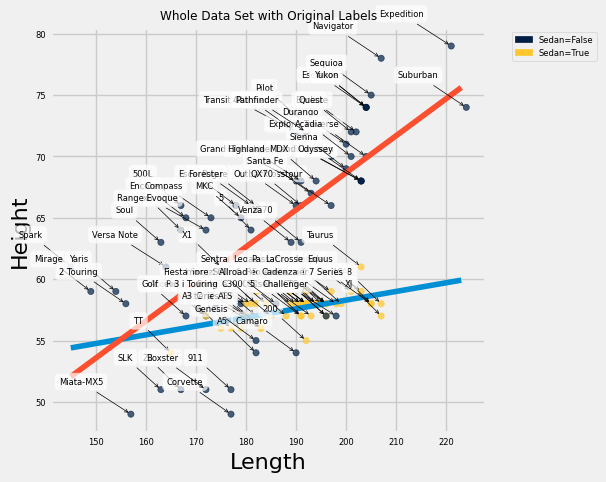

In [7]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, xlabel, ylabel):
    return np.mean(standard_units(t.column(xlabel))*standard_units(t.column(ylabel)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

cars = Table().read_table('Cars2015.csv')

def is_sedan(car_type): 
    if car_type=="Sedan": 
        return True
    else:
        return False

sedan = cars.with_column("Sedan", cars.apply(is_sedan, 'Type'))
#cars.group('Type')
#feature1 = 'Length'
#feature2 = 'Weight'

feature1 = 'Length'
feature2 = 'Height'

sedan.scatter(feature1, feature2, group='Sedan', labels='Model')
def fit_two_lines(table, feature1, feature2):
    m_pos = slope(sedan.where('Sedan', True), feature1, feature2)
    b_pos = intercept(sedan.where('Sedan', True), feature1, feature2)
    m_neg = slope(sedan.where('Sedan', False), feature1, feature2)
    b_neg = intercept(sedan.where('Sedan', False), feature1, feature2)
    return m_pos, b_pos, m_neg, b_neg

m_pos, b_pos, m_neg, b_neg = fit_two_lines(sedan, feature1, feature2)
x_range = np.arange(min(sedan.column(feature1)), max(sedan.column(feature1)))
plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)
plots.title('Whole Data Set with Original Labels')


Here we first split the data randomly into training and test sets. Then we fit two regressional models to the training set, one for sedans and one for non-sedans. Then use these two regression models for classification. The model with the smallest absolute value of the residual wins. Instead of plotting the two regression models, we can plot the decision boundary of this classifier, which can be solved algebraically from the two regression lines. 

Training data size:  77 ; test data size 33
Error rate in training data 0.14285714285714285


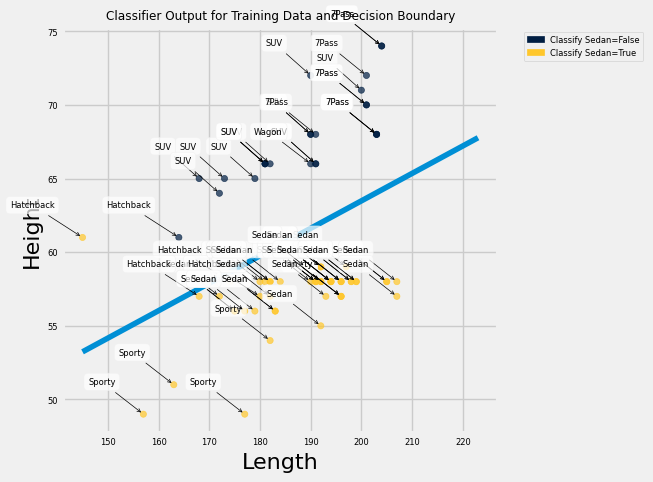

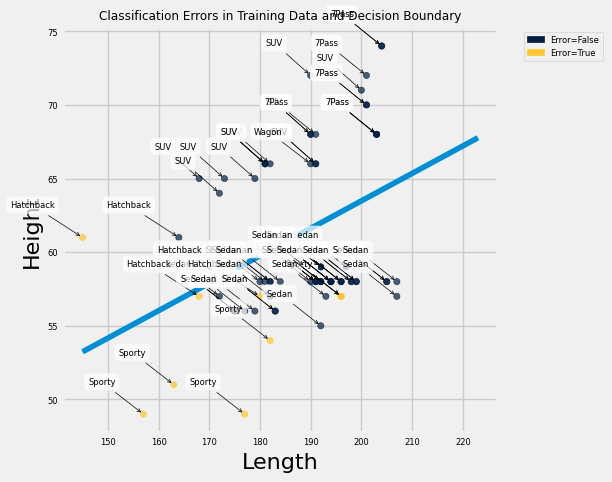

In [36]:
train_proportion = 0.7
# we randomly pick train_proportion to be the training data and the rest is test data
sedan_random = sedan.sample()
train_size = round(sedan.num_rows * train_proportion)
train_data = sedan_random.take(np.arange(train_size))
test_data = sedan_random.take(np.arange(train_size, sedan.num_rows))
print('Training data size: ', train_data.num_rows, "; test data size", test_data.num_rows)

m_pos, b_pos, m_neg, b_neg = fit_two_lines(train_data, feature1, feature2)

def decision_boundary(m1, b1, m2, b2):
    x0 = (b2-b1) / (m1-m2)
    y0 = m1*x0+b1
    x1 = 0
    y1 = (b1+b2)/2
    m = (y1-y0)/(x1-x0)
    b = y1
    return m, b

def classify_table_LR(table, m_pos, b_pos, m_neg, b_neg):
    residual_pos = table.column(feature2) - (table.column(feature1)*m_pos + b_pos)
    residual_neg = table.column(feature2) - (table.column(feature1)*m_neg + b_neg)
    is_sedan = abs(residual_pos) < abs(residual_neg)
    return is_sedan

def evaluate_classifier(table, m_pos, b_pos, m_neg, b_neg):
    is_sedan = classify_table_LR(table, m_pos, b_pos, m_neg, b_neg)
    table_with_output = table.with_column('Classify Sedan', classify_table_LR(table, m_pos, b_pos, m_neg, b_neg))
    is_error = (table_with_output.column('Sedan') != table_with_output.column('Classify Sedan'))
    return table_with_output.with_column('Error', is_error)
    
table_with_classification = evaluate_classifier(train_data, m_pos, b_pos, m_neg, b_neg)

table_with_classification.scatter(feature1, feature2, group='Classify Sedan', labels='Type')
m_boundary, b_boundary = decision_boundary(m_pos, b_pos, m_neg, b_neg)

#plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)
plots.plot(x_range, x_range*m_boundary+b_boundary)

plots.title('Classifier Output for Training Data and Decision Boundary')

table_with_classification.scatter(feature1, feature2, group='Error', labels='Type')
#plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)

plots.plot(x_range, x_range*m_boundary+b_boundary)
plots.title('Classification Errors in Training Data and Decision Boundary')

print("Error rate in training data", 
      np.count_nonzero(table_with_classification.column('Error')) / table_with_classification.num_rows)


It's not enough to evaluate the classifier on the training data. We should also observe its performance on the test data. 

Classification error rate in test data 0.36363636363636365


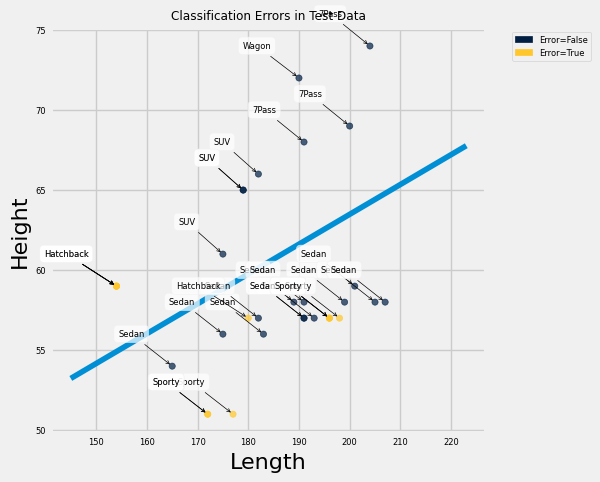

In [37]:
table_with_classification = evaluate_classifier(test_data, m_pos, b_pos, m_neg, b_neg)

table_with_classification.scatter(feature1, feature2, group='Error',labels='Type')
#plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)

plots.plot(x_range, x_range*m_boundary+b_boundary)

plots.title('Classification Errors in Test Data')

print("Classification error rate in test data", 
      np.count_nonzero(table_with_classification.column('Error')) / table_with_classification.num_rows)

### Non-parametric Classifier basd on k-Nearest Neighbors 

To compare with the regression-based "parametric" approach, which models the data with parameters (slope and intercept), we now build a non-parametric classifier based on the k-nearest neighbors. Here we only evaluate the classifier on the test set since the training set should perform close to 100% accuracy. 

In [10]:

def distance_row_to_table(row, table, feature1, feature2):
    feature_vec = make_array(row.item(feature1), row.item(feature2))
    table_matrix = np.matrix([table.column(feature1), table.column(feature2)]).transpose()
    distance_matrix = np.tile(feature_vec, [table.num_rows, 1]) - table_matrix
    return np.squeeze(np.array(np.sqrt(np.square(distance_matrix).sum(1))))

test_index = 10
distances = distance_row_to_table(test_data.row(test_index), train_data, feature1, feature2)

train_data_with_distance = train_data.with_column('Distance', distances).move_column('Distance', 0)
print('Test item', test_data.take(test_index))
train_data_with_distance.sort('Distance')


Test item Make | Model | Type   | LowPrice | HighPrice | Drive | CityMPG | HwyMPG | FuelCap | Length | Width | Wheelbase | Height | UTurn | Weight | Acc030 | Acc060 | QtrMile | PageNum | Size  | Sedan
Audi | A5    | Sporty | 40       | 79.2      | FWD   | 20      | 26     | 17.7    | 182    | 73    | 108       | 54     | 39    | 4050   | 2.9    | 8      | 16.2    | 101     | Small | False


Distance,Make,Model,Type,LowPrice,HighPrice,Drive,CityMPG,HwyMPG,FuelCap,Length,Width,Wheelbase,Height,UTurn,Weight,Acc030,Acc060,QtrMile,PageNum,Size,Sedan
2.23607,BMW,3 Series GT,Sedan,32.95,62,AWD,24,36,15.8,183,71,111,56,38,3485,2.6,6.3,14.9,106,Small,True
2.23607,Cadillac,ATS,Sedan,33.215,51.435,AWD,21,31,16.5,183,71,109,56,37,3420,2.5,6.5,14.9,115,Small,True
3,Volkswagon,Jetta,Sedan,16.215,31.12,FWD,25,36,14.5,182,70,104,57,37,3130,3.3,8.5,16.5,219,Small,True
3.60555,Mazda,3 i Touring,Sedan,16.945,26.595,FWD,30,41,13.2,180,71,106,57,38,2875,3.2,8.3,16.6,179,Small,True
3.60555,Mazda,3 i Touring,Sedan,16.945,26.595,FWD,30,41,13.2,180,71,106,57,38,2875,3.2,8.3,16.6,179,Small,True
3.60555,Hyundai,Elantra,Sedan,17.259,22.6,FWD,28,38,12.8,179,70,106,56,36,2770,3.4,9.5,17.2,149,Small,True
4.12311,Chevrolet,Cruze LS,Sedan,16.17,25.66,FWD,24,36,15.6,181,71,106,58,38,3140,3.7,9.8,17.6,119,Small,True
4.24264,Mercedes,C300,Sedan,38.4,71.9,AWD,24,31,17.4,185,71,112,57,38,3670,2.7,6.8,15.2,181,Small,True
4.47214,Dodge,Dart,Sedan,16.495,23.795,FWD,23,35,14.2,184,72,106,58,38,3260,3.4,9.3,17.2,128,Small,True
4.47214,Subaru,Impreza,Sedan,18.195,23.295,AWD,27,36,14.5,180,69,104,58,38,3015,3.7,9.2,17.2,205,Small,True


In [11]:
K = 5 # an odd number
def classify_KNN(test_row, train_table, K, feature1, feature2):
    distances = distance_row_to_table(test_row, train_table, feature1, feature2)
    train_data_with_distance = train_table.with_column('Distance', distances).move_column('Distance', 0)
    sorted_table = train_data_with_distance.sort('Distance')
    knn_labels = sorted_table.take(np.arange(K)).column('Type')
    n_sedan = np.count_nonzero(knn_labels == 'Sedan')
    if n_sedan > round(K/2):
        return True
    else:
        return False
    
KNN_output = make_array()
for i in range(test_data.num_rows):
    is_sedan = classify_KNN(test_data.row(i), train_data, K, feature1, feature2)
    KNN_output = np.append(KNN_output, is_sedan)

test_data_with_KNN = test_data.with_column('KNN output', KNN_output).move_column('KNN output', 3)
errors = (test_data.column('Type') == 'Sedan') != test_data_with_KNN.column('KNN output')
test_data_with_errors_KNN = test_data_with_KNN.with_column("Error", errors).move_column('Error', 4)
print("Accuracy of KNN on test data: ", np.count_nonzero(errors) / test_data.num_rows)
test_data_with_errors_KNN.where('Error', True)


Accuracy of KNN on test data:  0.21212121212121213


Make,Model,Type,KNN output,Error,LowPrice,HighPrice,Drive,CityMPG,HwyMPG,FuelCap,Length,Width,Wheelbase,Height,UTurn,Weight,Acc030,Acc060,QtrMile,PageNum,Size,Sedan
Ford,Focus,Hatchback,1,True,17.17,29.17,FWD,28,38,12.4,179,72,104,58,39,2990,3.4,9.2,17.1,136,Small,False
Ford,Focus,Hatchback,1,True,17.17,29.17,FWD,28,38,12.4,179,72,104,58,39,2990,3.4,9.2,17.1,136,Small,False
Audi,A5,Sporty,1,True,40,79.2,FWD,20,26,17.7,182,73,108,54,39,4050,2.9,8,16.2,101,Small,False
Hyundai,Genesis,Sporty,1,True,26.75,34.6,RWD,17,26,17.2,182,73,111,55,40,3460,2.5,6.2,14.6,150,Small,False
Audi,A5,Sporty,1,True,40,79.2,FWD,20,26,17.7,182,73,108,54,39,4050,2.9,8,16.2,101,Small,False
Chevrolet,Corvette,Sporty,1,True,55,83,RWD,17,29,18,177,74,107,49,38,3470,2,4.3,12.6,118,Small,False
Dodge,Challenger,Sporty,1,True,26.995,58.295,RWD,15,24,18.5,198,76,116,57,39,4195,2.5,6.5,14.9,127,Large,False


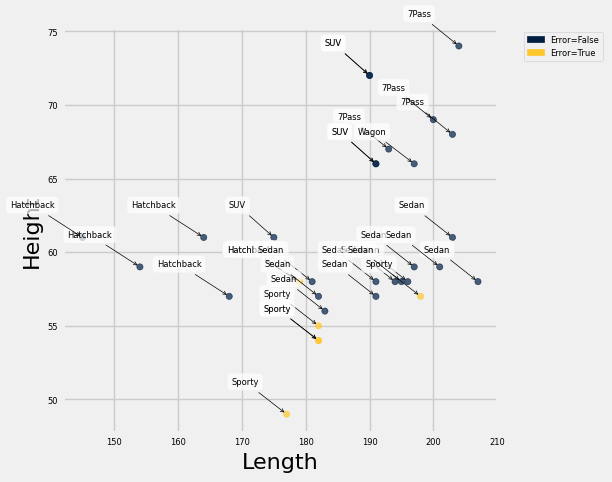

In [12]:
test_data_with_errors_KNN.scatter(feature1, feature2, group='Error',labels='Type')


### Linear Discriminant Analysis

As a third example of a parametric classifier that is based on linear models, we will consider the Linear Discriminant Analysis, which aims to maximize the separation of the positive and negative examples by projecting the data into a smaller space. In our example, since the original data live in a 2D space with two features, we seek to project the data onto a line (1D) and visualize the data in this reduced dimension through histograms. We start by projecting the data onto a linear similar to the decision boundary, which gives terrible separation between the two classes. 

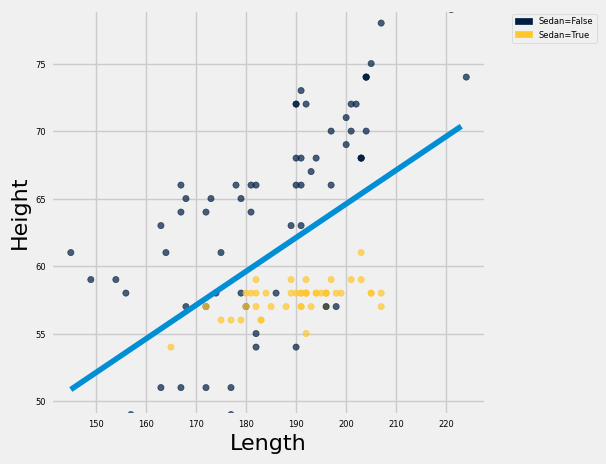

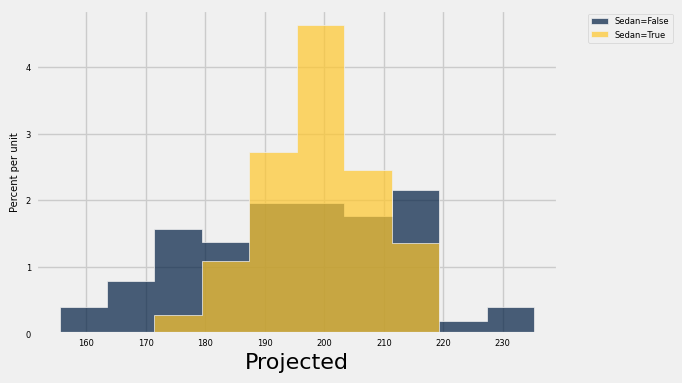

In [ ]:
# project x vector onto another vector v, returns a scalar value 
def norm(v):
    return np.sqrt(np.square(v).sum())

def project(x_vec, v):
    return np.dot(x_vec, v) / norm(v)


# here we project the data in a table onto a vector 

def project_table_onto_v(v, table, feature1, feature2):
    projected_coord = make_array()
    for i in np.arange(table.num_rows):
         r = table.row(i)
         feature_vec = make_array(r.item(feature1), r.item(feature2))
         projected_coord = np.append(projected_coord, project(feature_vec, v))
    return projected_coord

# v can be any two-dimensional vector. To limit the number of solutions, we turn it into a unit vector 
v = make_array(4, 1)
v = v / norm(v)

sedan.scatter(feature1, feature2, group='Sedan')

# here we plot the line through the center that is parallel to the direction of projection. Notice this line can be shifted vertically
#  and it does not change the separation between classes 

center = np.average(sedan.column(feature1)), np.average(sedan.column(feature2))
plots.ylim(min(sedan.column(feature2)), max(sedan.column(feature2)))
plots.plot(x_range, (v[1]/v[0])*(x_range - center[0]) + center[1]) 

sedan.with_column('Projected', project_table_onto_v(v, sedan, feature1, feature2)).hist('Projected', group='Sedan')



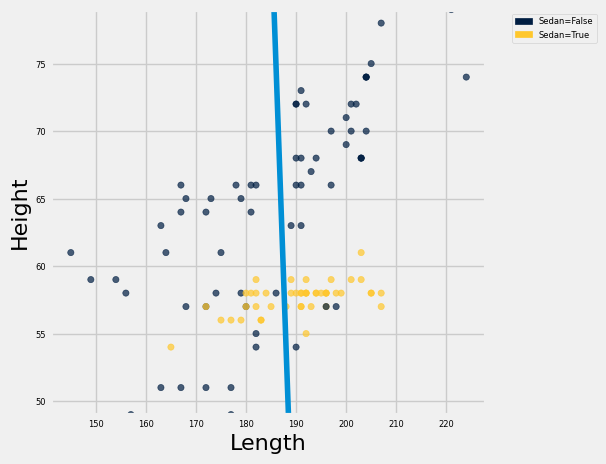

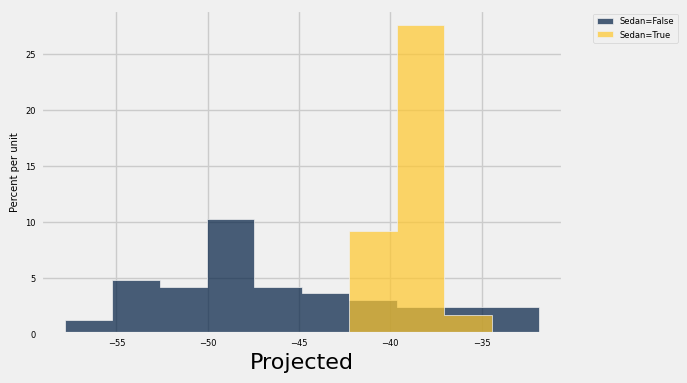

In [ ]:
# we define the LDA loss function as -abs(mu1-mu2)/(sd1*sd2). So classes that are widely separated 
# will minimize this value. Since v is a unit vector, it can be parameterized by the angle theta

def LDA_loss(theta):
    v = make_array(np.cos(theta), np.sin(theta))
    sedan_with_projections = sedan.with_column('Projected', project_table_onto_v(v, sedan, feature1, feature2))
    pos = sedan_with_projections.where('Type', are.equal_to('Sedan')).column('Projected')
    neg = sedan_with_projections.where('Type', are.not_equal_to('Sedan')).column('Projected')
    m_pos, sd_pos = np.average(pos), np.std(pos)
    m_neg, sd_neg = np.average(neg), np.std(neg)
    return - abs(m_pos - m_neg) / (sd_pos*sd_neg)

# In standard LDA, the solution is found by solving eigenvalues of matrices. Here we use the numerical optimizer
# from the previous section on regression 

theta = minimize(LDA_loss)

v = make_array(np.cos(theta), np.sin(theta))

sedan.scatter(feature1, feature2, group='Sedan')

center = np.average(sedan.column(feature1)), np.average(sedan.column(feature2))
plots.ylim(min(sedan.column(feature2)), max(sedan.column(feature2)))
plots.plot(x_range, (v[1]/v[0])*(x_range - center[0]) + center[1]) 

sedan.with_column('Projected', project_table_onto_v(v, sedan, feature1, feature2)).hist('Projected', group='Sedan')


Finally, we can use the projection found by LDA to construct a classifier. A data point is projected using the same direction found in LDA, then we compare the z-score under each of the models. The model that produces the smallest absolute value of the z-score wins. This is equivalent to use two 2-dimensional Gaussian distributions to perform the classification. 

Accuracy of LDA classifier on test data:  0.9090909090909091


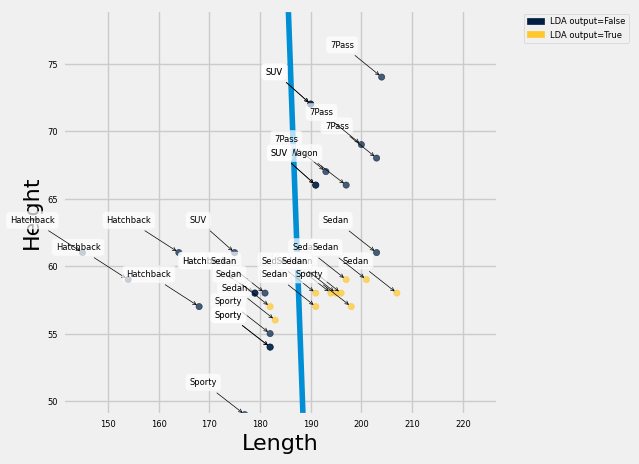

In [33]:
train_with_projections = train_data.with_column('Projected', project_table_onto_v(v, train_data, feature1, feature2))
pos = train_with_projections.where('Type', are.equal_to('Sedan')).column('Projected')
neg = train_with_projections.where('Type', are.not_equal_to('Sedan')).column('Projected')
m_pos, sd_pos = np.average(pos), np.std(pos)
m_neg, sd_neg = np.average(neg), np.std(neg)

def classify_LDA(table, v, feature1, feature2, m_pos, sd_pos, m_neg, sd_neg):
    projections = project_table_onto_v(v, table, feature1, feature2)
    z_pos = (projections - m_pos) / sd_pos
    z_neg = (projections - m_neg) / sd_neg
    return (abs(z_pos) < abs(z_neg))


LDA_classifer_output = classify_LDA(test_data, v, feature1, feature2, m_pos, sd_pos, m_neg, sd_neg)
test_data_with_LDA_output = test_data.with_column('LDA output', LDA_classifer_output).move_column('LDA output', 0)
test_data_with_LDA_output.scatter(feature1, feature2, group='LDA output', labels='Type')



center = np.average(sedan.column(feature1)), np.average(sedan.column(feature2))
plots.ylim(min(sedan.column(feature2)), max(sedan.column(feature2)))
plots.plot(x_range, (v[1]/v[0])*(x_range - center[0]) + center[1]) 

print('Accuracy of LDA classifier on test data: ', 
      np.count_nonzero(test_data_with_LDA_output.column('LDA output') == (test_data.column('Type') == 'Sedan')) / test_data.num_rows)